In [119]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)

from parallel import Invoker

In [120]:
# Calculate params for simulations
from numpy import arange,linspace,logspace
NUM_SIMULATED_CORES = 16
F_STEP = 2
#FunctionRange = arange(2,NUM_SIMULATED_CORES+F_STEP,F_STEP) # interval is open
FunctionRange = [16]
#GroupingRange = logspace(base=2,start=0,stop=4,num=5)
GroupingRange = [1,4,16]

import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor
            
def filter_configs_by_cores(num_funcs,grouping,divisor_list):
    num_queues = num_funcs / grouping
    if num_queues in divisor_list:
        return True
        return (num_funcs,grouping,cores_per_q)
    
# Cores_per_q is always even for now by virtue of filter_configs_by_cores
def setup_final_config(num_funcs,grouping):
    num_queues = num_funcs / grouping
    cores_per_q = NUM_SIMULATED_CORES / num_queues
    rdict = { 'funcs': int(num_funcs), 'grouping' : int(grouping), 'cores_per_q': int(cores_per_q), 'stime':1}
    if rdict['grouping'] == 4:
        rdict['stime'] = .9
    elif rdict['grouping'] == 1:
        rdict['stime'] = .8
    return rdict
    
core_divisors = list(divisorGenerator(NUM_SIMULATED_CORES))
iterator_combinations = ((fr,gr) for fr in FunctionRange for gr in GroupingRange )
possible_combos = filter(lambda x : filter_configs_by_cores(x[0],x[1],core_divisors), iterator_combinations)
final_params = list(map(lambda x : setup_final_config(x[0],x[1]), possible_combos)) # don't run this cell repeatedly

In [126]:
#### Run simulations for various function numbers and various function grouping
def setup_sim(func_group,core_group,num_functions,stime,load_range):
    invokerArgs = {'runnableTarg' : 'qmodel_dispatch',
                  'mode': 'sweep_A',
                  'numProcs' : 2,
                  'NumWorkers' : NUM_SIMULATED_CORES,
                   'argrange': load_range,
                   'NumFunctions': num_functions,
                   'FunctionGrouping': func_group,
                   'CoreGrouping': core_group,
                   'FixedTime' : stime,
                   'RequestsToSimulate': 250000
                  }
    return invokerArgs

import pandas

MAX_LD_NUM = 0.8/float(NUM_SIMULATED_CORES)

def conv_to_max(abs_num):
    return MAX_LD_NUM/float(abs_num)
    
# Return a pandas dataframe with all results
def run_sims(func_group,core_group,num_functions,stime,load_range):
    args = setup_sim(func_group,core_group,num_functions,stime,load_range)
    simulationController = Invoker( **args )
    print('Starting simulation for \(Nf,G\)',num_functions,core_group)
    simulationController.startProcs()
    simulationController.joinProcs()
    # Get results
    numProcs = args['numProcs']
    
    results = [ simulationController.getResultsFromQueue(idx) for idx in range(numProcs) ]
    flat_results = [ y for x in results for y in x ]
    
    # Remap results to the following format to import to pandas
    # { 'loads' : [ list of data points ]
    #    <Percentile Value> : [ list of data points ]
    # }
    def add_key_or_append(d,k,v):
        if k in d.keys():
            d[k].append(v)
        else:
            d[k] = []
            
    remap_dict = {}
    
    for x in flat_results:
        for load,times in x.items():
            remap_dict[conv_to_max(load)] = times
    sorted_dict = {k:v for k,v in sorted(remap_dict.items(),key=lambda x : x[0])}
    f_dict = {}
    
    for load,time_dict in sorted_dict.items():
        # Append all loads to dict
        add_key_or_append(f_dict,'load',load)
        for p,v in time_dict.items():
            add_key_or_append(f_dict,str(p),v)      

    return args,pandas.DataFrame.from_dict(f_dict)

from numpy import linspace,geomspace
low_range= linspace(1,0.15,10)
high_range = linspace(0.15,MAX_LD_NUM,40)
load_range = numpy.concatenate([low_range,high_range])
### Run a group of simulations for each pair of num_functions/function_groupings
#load_range = geomspace(1,MAX_LD_NUM,200)
#args,ex_df = run_sims(4,4,16,load_range)
sims_gen = list(map(lambda x : run_sims(x['grouping'],x['cores_per_q'],x['funcs'],x['stime'],load_range),final_params))
;
print('Simulations done!!')

Starting simulation for \(Nf,G\) 16 1
Starting simulation for \(Nf,G\) 16 4
Starting simulation for \(Nf,G\) 16 16
Simulations done!!


In [127]:
## Make 'ideal' data series
ideal_params = [{ 'funcs': 16, 'grouping' : 16, 'cores_per_q': 16, 'stime': 0.8}]
sim_ideal = list(map(lambda x : run_sims(x['grouping'],x['cores_per_q'],x['funcs'],x['stime'],load_range),ideal_params))
;
print('Running ideal simulation is done!!')

Starting simulation for \(Nf,G\) 16 16
Running ideal simulation is done!!


Figure already exists with fname grouping_comparisons_16funcs_uniform.pdf will back up!


/Users/msutherl/Documents/epfl_phd/PARSA/Research/HARNESS/qmodels/venv/lib/python3.8/site-packages/matplotlib/figure.py:458: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(


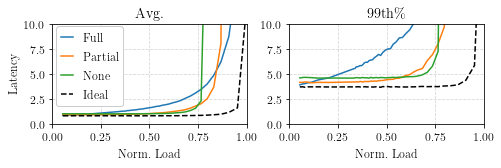

In [130]:
####### Create 50th and 99th% plots for various G
graph_us = {}
graph_ideal = {}
def init_or_add_val(d,k,k2,v):
    if k not in d.keys():
        d[k] = {}
    if k2 not in d[k].keys():
        d[k][k2] = v
    else:
        print('WARN: WOULD HAVE OVERWRITTEN DATA')

for args,df in sims_gen:
    tup_to_k2 = (args['FunctionGrouping'],args['CoreGrouping'])
    init_or_add_val(graph_us,args['NumFunctions'],tup_to_k2,df)
    
for args,df in sim_ideal:
    tup_to_k2 = (args['FunctionGrouping'],args['CoreGrouping'])
    init_or_add_val(graph_ideal,args['NumFunctions'],tup_to_k2,df)
    
# Generate plots
import matplotlib.pyplot as plt
import numpy
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
fontdir = {'size':12,'family':'serif'}
rc('font',**fontdir)
rc('text',usetex=True)

labels_for_grouping = {16: "None", 4: "Partial", 1: "Full"}
#print(graph_us[16])

for nfuncs,data in graph_us.items():
    fname = 'grouping_comparisons_'+str(nfuncs)+'funcs_uniform.pdf'
    if os.path.exists(fname):
        print('Figure already exists with fname',fname,'will back up!')
        fname_bak = fname + '.bak'
        os.rename(fname,fname_bak)
        
    # Get ideal simulation data to match this nfuncs
    data_ideal = graph_ideal[nfuncs]

    with PdfPages(fname) as pp:
        f,axarr = plt.subplots(1,2,figsize=(7,2.5))
        for tup, values in data.items():
            grouping = tup[0]
            cores_per_q = tup[1]
            num_queues = int(nfuncs / grouping)
            mathstring = r" $("+str(num_queues)+"\\times"+str(cores_per_q)+")$"
            #l = 'G = ' + str(grouping) + mathstring
            values.plot(x='load',y='50',ax=axarr[0],label=labels_for_grouping[grouping])
            values.plot(x='load',y='99',ax=axarr[1],label=labels_for_grouping[grouping])
            
        for tup, values in data_ideal.items():
            values.plot(x='load',y='50',ax=axarr[0],label='Ideal',style='k--')
            values.plot(x='load',y='99',ax=axarr[1],label='Ideal',style='k--')

        for i,ax in enumerate(axarr):
            ax.grid(True,axis='both',linestyle='--',alpha=0.5)
            ax.get_legend().remove()


        handles, labels = axarr[0].get_legend_handles_labels()


        axarr[0].set_ylabel('Latency')
        axarr[0].set_xlabel('Norm. Load')
        axarr[1].set_xlabel('Norm. Load')
        axarr[0].set_ylim(0,10)
        axarr[1].set_ylim(0,10)
        axarr[0].set_xlim(0,1)
        axarr[1].set_xlim(0,1)
        axarr[0].set_xticks(numpy.linspace(0,1,5))
        axarr[1].set_xticks(numpy.linspace(0,1,5))
        axarr[0].set_title('Avg.')
        axarr[1].set_title('99th\%')

        f.legend(handles,labels,loc='upper left',bbox_to_anchor=(0.1,0.82),ncol=1,fontsize=12,frameon=True,framealpha=1,
            handlelength=1,columnspacing=1)

        f.tight_layout()
        pp.savefig()
        f.show()